# TP1 - Compressão e Descompressão de Imagem

### Alunos:

Vinicius Silva Gomes - 2021421869

João Antonio Oliveira Pedrosa - 2019006752

# Compressão de Imagem

Fizemos dois métodos de compressão para o trabalho. O primeiro deles é inspirado na compressão realizada pelo JPEG, se diferenciando na forma de codificar os bits da imagem para salvar em disco e, consequentemente, na sua decodificação. O segundo deles é um método mais matemático, que é a compressão através da Decomposição em Valores Singulares.

Ambos os métodos serão melhor detalhados ao longo do código e previamente antes dele ser apresentado.

In [3]:
# Library import

%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

In [4]:
# Variables and auxiliar functions

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def pad_img(img):
    # Padding image
    img_shape = img.shape

    lin    = img_shape[0]
    col    = img_shape[1]
    xpad   = (SQ - lin % SQ) % SQ
    ypad   = (SQ - col % SQ) % SQ

    padded_img = img.copy()
    padded_img = np.append(padded_img, np.full((xpad, col)        , 255), axis = 0)
    padded_img = np.append(padded_img, np.full((lin + xpad, ypad) , 255), axis = 1)
    
    return padded_img

def unpad_img(img, shape):
    # Unpadding image
    img_shape = shape

    lin    = img_shape[0]
    col    = img_shape[1]
    xpad   = (SQ - lin % SQ) % SQ
    ypad   = (SQ - col % SQ) % SQ

    return img[:-xpad, :-ypad] 

SQ = 8

# Default quantization matrix implemented by JPEG compression method
quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                        [12, 12, 14, 19, 26, 58, 60, 55],
                        [14, 13, 16, 24, 40, 57, 69, 56],
                        [14, 17, 22, 29, 51, 87, 80, 62],
                        [18, 22, 37, 56, 68, 109, 103, 77],
                        [24, 35, 55, 64, 81, 104, 113, 92],
                        [49, 64, 78, 87, 103, 121, 120, 101],
                        [72, 92, 95, 98, 112, 100, 103, 99]])

Dimensões da imagem: 512x512
Tamanho da imagem (em disco): 0.262178 MB / 262.178 kB


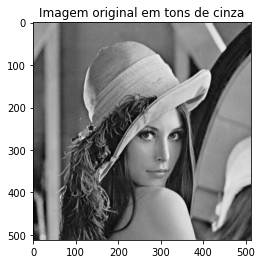

In [5]:
# Importing the image and information about it's dimensions and size

src_img = cv2.imread('lena512.pgm', 0)
src_img_size = os.stat('lena512.pgm').st_size

print("Dimensões da imagem: {}x{}".format(src_img.shape[1], src_img.shape[0]))
print("Tamanho da imagem (em disco): {} MB / {} kB".format(src_img_size/10 ** 6, src_img_size/10 ** 3))

plt.title("Imagem original em tons de cinza")
plt.imshow(src_img, cmap="gray")

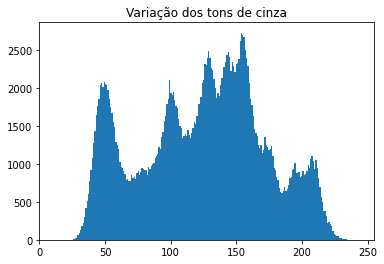

In [6]:
# Histogram with image gray levels
padded_img = pad_img(src_img)
flattered_img = padded_img.ravel()

plt.hist(flattered_img, 256, [0,255]);
plt.xlim([0, 255])
plt.title("Variação dos tons de cinza")
plt.show()

## Primeiro método de Compressão
Transformada Discreta do Cosseno + Quantização através da tabela padrão utilizada pelo JPEG + Codificação através de array que minimiza a incidência de zeros.

Para este método de compressão, é realizada a transformação da imagem do domínio espacial para o domínio de frequência. Essa transformação é feita através da Transformada Discreta do Cosseno em blocos de tamanho 8x8. Para que não haja problemas com as dimensões da imagem, antes de sofrer a transformada, a imagem passar por um processo de padding para que ela seja múltipla de 8.

Após a transformada, a imagem é quantizada por meio de uma tabela de quantização. Essa tabela tem como função minimizar os coeficientes de alta frequência e manter somente os de baixa e média frequência (faixa de frequência visível a olho nu). A tabela de quantização utilizada é mesma utilizada pelo JPEG, que possui uma taxa de compressão satisfatória e não prejudica a visualização do conteúdo da imagem.

Por fim, a imagem será codificada e salva em disco. A codificação acontece bloco a bloco e é feita de forma que cada fim de linha é representado por um caractere (127) e cada fim de bloco é representado por outro caractere (128). Os 0s a direita são omitidos e apenas os caracteres delimitadores e os coeficientes diferentes de 0 são salvos. Dessa forma, graças a grande quantidade de coeficientes 0 obtidos através da DCT + Quantização, um bloco 8x8 pode ser reduzido para um array unidimensional muito menor.

Com isso, serão salvos as dimensões originais da imagem, sem padding, e os blocos codificados pelo algoritmo. Salvando dessa forma, é possível recriar a imagem original (com algumas perdas graças a DCT + Quantização) usando muito menos espaço de armazenamento em disco.

In [37]:
# Function that receives a SQ x SQ block and applies DCT Transform + Quantization

# Function to transform any number smaller than 2^32 into a 8bit array
def num_to_array(num):
    bits     = [1 if (num & (1 << i)) else 0 for i in range(32)]
    
    response = []
    for i in range(4):
        cur_num = 0
        for j in range(8):
            if(bits[i*8 + j]):
                cur_num += (1 << j)
        response.append(cur_num)
    
    return response

# Function to reverse a 8bit array into the original number
def array_to_num(arr):
    bits = []
    for i in range(4):
        for j in range(8):
            if(arr[i] & (1 << j)):
                bits.append(1)
            else:
                bits.append(0)
    
    num = 0
    for i in range(32):
        if(bits[i]):
            num += (1 << i)
    
    return num
    
# Apply DCT to a SQxSQ image block
def apply_dct(block):
    image = block.copy()
    
    image -= 128
    image =  image.astype(float)
    return cv2.dct(image)

# Apply IDCT to a SQxSQ image block
def apply_idct(block):
    image = block.copy()
    image =  image.astype(float)
    image = cv2.idct(image)
    image += 128
    return image

# Used to guarantee consistent numbers in simple array
def f(num):
    if num == 128:
        return 126
    if num == 127:
        return 126
    
    return num

def desimplify_block(block):
    desimple = []
    line     = []
    for num in block:
        if num == 128:
            break
        elif num == 127:
            line += [0 for i in range(SQ - len(line))]
            desimple.append(line)
            line = []
        else:
            line.append(num)
            
    # Padding
    for i in range(SQ - len(desimple)):
        desimple.append([0] * 8)
    
    return np.array(desimple)

# Simplify the block writing an unidimensional array divided by arbitrary codes:
# 127  is used to store line ending
# 128 is used to store block ending
# That way we can simplify a SQxSQ block into a smaller array and then convert it back to a SQxSQ block
def simplify_block(block):
    simple = []
    for i in range(SQ):
        # Transform line
        line = []
        for j in reversed(range(SQ)):
            if line:
                line.append(f(block[i][j]))
            elif(block[i][j] != 0):
                line.append(127)
                line.append(f(block[i][j]))
        
        line.reverse()
        simple += line
    
    simple.append(128)
    
    return simple

# Encode a SQxSQ block, returning the simplified version of the block
def encode_block(block):
    local_dct        = apply_dct(block)
    local_quant      = local_dct / quant_matrix
    local_quant      = local_quant.round()
    
    return simplify_block(local_quant)

# Decode a SQxSQ block, returning the original block from the image
def decode_block(block):
    local_block = desimplify_block(block)
    
    return apply_idct(local_block * quant_matrix)

def encode_img(img):
    # Adding dimensions to start of array
    xshape, yshape = img.shape
    encoded = num_to_array(xshape) + num_to_array(yshape)
    
    padded_img = pad_img(img)
    
    lin = padded_img.shape[0]
    col = padded_img.shape[1]
    for l in tqdm(range(0, lin, SQ)):
        for c in range(0, col, SQ):
            encoded += encode_block(padded_img[l:l+SQ, c:c+SQ])
    
    return np.array(encoded, dtype=np.int8)
    
def decode_img():
    enc = np.load('results/compressed_dct.npy')
    
    xshape = array_to_num(np.array(enc[0:4]))
    yshape = array_to_num(np.array(enc[4:8]))
    
    img = np.array(enc[8:])

In [36]:
# encoded_img = encode_img(src_img)
# np.save('results/compressed_dct.npy', encoded_img)

decoded_img = decode_img()

# plt.title("Original")
# plt.imshow(src_img, cmap="gray",)
# plt.figure()

# plt.title("Compressed")
# plt.imshow(dct_full, cmap="gray")

# print("RMSE:", rmse(padded_img, dct_full))
# print("PSNR:", psnr(padded_img, dct_full))

[  16  127    1 ...   -1  127 -128]


## Segundo método de compressão
Compressão baseado na Decomposição em Valores Singulares.

A compressão por Decomposição em Valores Singulares se baseia na propriedade de que qualquer matriz pode ser decomposta em 3 matrizes U, Σ e V; de modo que a multiplicação IMG = UΣV resulta na matriz que originou a decomposição.

A compressão desse método se baseia no fato que essas matrizes possuem tamanho inferior ao tamanho original da imagem e elas são dependentes do número de valores singulares que serão usados para recompor a imagem. Quanto mais valores singulares usados, maior será a fidelidade da imagem reconstruída e, consequentemente, menor será a compressão.

No exemplo que foi codificado, são usados aproximadamente 20% dos valores singulares da matriz. Com essa quantidade de valores, é possível reconstruir a imagem de modo que é possível identificar claramente o conteúdo presente nela, mas os ruídos e as perdas de cores são bem notáveis. Além disso, é possível obter uma taxa de compressão relativamente boa, como pode ser observado nos prints na próxima célula.

In [32]:
# Compress the image, saving the U, Σ and V matrices in the disk
def svd_compression(img):
    U, sigma, V = np.linalg.svd(img, full_matrices=False) # Calculates U, V and the singular values of the original matrix
    
    rank = len(sigma)
    
    k = round(0.2 * rank) # Estimate the number of singular values
        
    U_new = U[:,:k]
    V_new = V[:k,:]
    S_new = np.zeros((k, k), int)
    
    for i in range(k):
        S_new[i][i] = sigma[i]
        
    file = open("results/compressed_svd.bin" ,"wb")
    
    np.save(file, U_new)
    np.save(file, S_new)
    np.save(file, V_new)
    
    file.close()
    
    return k

# Load matrices from disk into memory and perform multiplication to get the original matrix
def svd_decompression():
    file = open("results/compressed_svd.bin" ,"rb")
    
    U = np.load(file)
    sigma = np.load(file)
    V = np.load(file)
    
    file.close()
        
    uncompressed_img = np.dot(np.dot(U, sigma), V)
    
    return uncompressed_img

# Calculate the compression rate for SVD compression
def compression_rate(img, singular_values):
    original_size = img.shape[0] * img.shape[1]
    compressed_size = singular_values * (1 + img.shape[0] + img.shape[1])
    
    return original_size / compressed_size

RMSE: 4.11676101946465
PSNR: 35.8396904753857
Compression Rate: 2.507355332376853


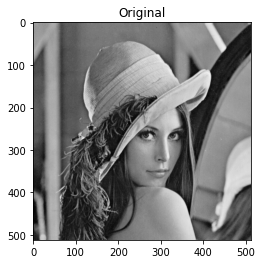

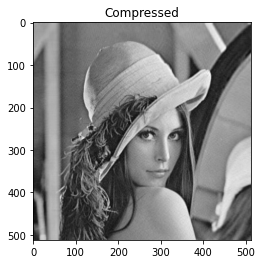

In [33]:
singular_values = svd_compression(src_img)

uncompressed_img = svd_decompression()

plt.title("Original")
plt.imshow(src_img, cmap="gray",)
plt.figure()

plt.title("Compressed")
plt.imshow(uncompressed_img, cmap="gray")

print("RMSE:", rmse(padded_img, uncompressed_img))
print("PSNR:", psnr(padded_img, uncompressed_img))
print("Compression Rate:", compression_rate(src_img, singular_values))